In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [2]:
theano.config.floatX ='float32'
# print(theano.config)
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
#         print(val)
#         val = quad(self._func, self.lower, self.upper, args=tuple(inputs))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [3]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to_value(u.TeV), fit_range.to_value(u.TeV))
    return [a[idx[0]:idx[1]] for a in arr]

In [22]:
def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=None, efficiency=1):
    
    amplitude *= 1e-11
    
    predicted_signal_per_observation = []
    for observation in observations:
        obs_bins = observation.on_vector.energy.bins.to_value(u.TeV)


        aeff_bins = observation.aeff.energy
        e_reco_bins = observation.edisp.e_reco
        e_true_bins = observation.edisp.e_true

        lower =  e_true_bins.lo.to_value(u.TeV)
        upper = e_true_bins.hi.to_value(u.TeV)

        energy = T.dscalar('energy')
        amplitude_ = T.dscalar('amplitude_')
        alpha_ = T.dscalar('alpha_')
        beta_ = T.dscalar('beta_')

        func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))

        counts = []
        for a, b in zip(lower, upper):
            c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
            counts.append(c)

        counts = T.stack(counts)
        aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)

        counts *= efficiency * aeff
        counts *= observation.livetime.to_value(u.s)
        edisp = observation.edisp.pdf_matrix
        edisp = edisp

        predicted_signal_per_observation.append(T.dot(counts, edisp))

    predicted_counts = T.sum(predicted_signal_per_observation, axis=0)
    if fit_range is not None:
        idx = np.searchsorted(obs_bins, fit_range.to_value(u.TeV))
        predicted_counts = predicted_counts[idx[0]:idx[1]]

    return predicted_counts

In [38]:
observations, fit_range = load_spectrum_observations('fact', low_binning=True)
# observation = obs_list[1]
obs_alpha = observations[0].alpha[0]
energy_bins = observations[0].on_vector.energy.bins
print(len(energy_bins))
observations, fit_range # [obs.alpha for obs in observations]

41


([<gammapy.spectrum.observation.SpectrumObservation object at 0x7fad8e64cdd8>],
 <Quantity [ 0.4, 30. ] TeV>)

In [39]:
def get_observed_counts(observations, fit_range=None):
    on_data = []
    off_data = []
    
    for observation in observations:
        on_data.append(observation.on_vector.data.data.value)
        off_data.append(observation.off_vector.data.data.value)
    on_data = np.sum(on_data, axis=0)
    off_data = np.sum(off_data, axis=0)
    if fit_range is not None:
        on_data, off_data = apply_range(on_data, off_data, fit_range=fit_range, bins=energy_bins)
    
    return on_data, off_data

In [53]:
on_data, off_data = get_observed_counts(observations, fit_range=fit_range)
exposure_ratio = observations[0].alpha[0]   # 1/9 = 0.11111

model = pm.Model(theano_config={'compute_test_value': 'ignore'})

with model:

    amplitude = pm.TruncatedNormal('amplitude', mu=4, sd=2.5, lower=0, testval=4)
    alpha = pm.TruncatedNormal('alpha', mu=2.5, sd=1, lower=0, testval=2.5)
    beta = pm.TruncatedNormal('beta', mu=0.5, sd=0.5, lower=0, testval=0.5)
    
    efficiency = pm.Normal('epsilon', mu=1, sd=0.1)

    mu_s = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observations, fit_range=fit_range, efficiency=efficiency)

    mu_b = pm.Uniform('mu_b', shape=len(off_data), lower=0, upper=2 * np.max(off_data))
    
    b = pm.Poisson('background', mu=mu_b, observed=off_data)    
    s = pm.Poisson('signal', mu=mu_s + exposure_ratio * mu_b, observed=on_data)

In [54]:
model.test_point

{'amplitude_lowerbound__': array(1.3862944, dtype=float32),
 'alpha_lowerbound__': array(0.91629076, dtype=float32),
 'beta_lowerbound__': array(-0.6931472, dtype=float32),
 'mu_b_interval__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}

In [55]:
def interval_transform(x, a, b):
    return np.log(x - a) - np.log(b - x)

625it [00:08, 74.44it/s]


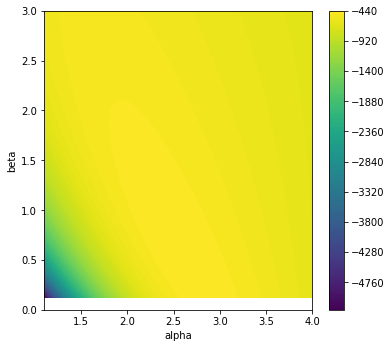

In [56]:
N = 25
betas = np.linspace(0, 3, N)
alphas = np.linspace(1.1, 4.0, N)

f = model.logp
zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
        
    p = f(amplitude_lowerbound__ = np.log(4.0), alpha_lowerbound__ = np.log(al), beta_lowerbound__= np.log(be), mu_b_interval__ = interval_transform(off_data + 0.005, 0, b=2*np.max(off_data)), epsilon=1 )
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=124)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

In [58]:
map_estimate = pm.find_MAP(model=model, start={'amplitude': 4.0, })
map_estimate

logp = -540.72, ||grad|| = 0.71322: 100%|██████████| 126/126 [00:08<00:00, 15.46it/s] 


{'amplitude_lowerbound__': array(1.2394896, dtype=float32),
 'alpha_lowerbound__': array(0.9286467, dtype=float32),
 'beta_lowerbound__': array(-0.81326425, dtype=float32),
 'mu_b_interval__': array([-13.5019455 , -13.5019455 ,  -4.300796  ,  -0.9865841 ,
         -0.06064179,   0.03762129,  -0.40190127,  -0.63153327,
         -0.97534907,  -1.3940741 ,  -1.4406849 ,  -1.9665736 ,
         -2.3173316 ,  -2.368134  ,  -2.7009091 ,  -3.013194  ,
         -3.4533322 ,  -3.5193455 ,  -4.0743656 ,  -3.8114233 ,
         -4.406424  ,  -4.5046334 ,  -4.518237  ,  -4.826588  ,
         -5.3610706 ,  -6.378235  ,  -6.816144  ,  -6.061314  ,
        -13.5019455 , -13.5019455 ], dtype=float32),
 'amplitude': array(3.45385, dtype=float32),
 'alpha': array(2.5310814, dtype=float32),
 'beta': array(0.4434083, dtype=float32),
 'mu_b': array([4.1815024e-03, 4.1815024e-03, 4.0878304e+01, 8.2997083e+02,
        1.4816838e+03, 1.5567394e+03, 1.2250148e+03, 1.0609301e+03,
        8.3678046e+02, 6.0740491e

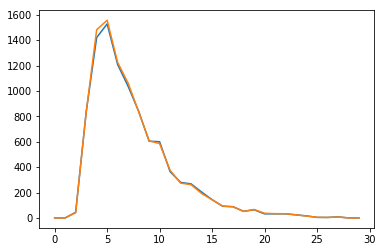

In [59]:
plt.plot(off_data)
plt.plot(map_estimate['mu_b'])

In [60]:
with model:
#     step1 = pm.Metropolis([mu_b])
#     step2 = pm.NUTS([amplitude, alpha, beta], target_accept=0.9)
#     trace = pm.sample(1000, step=[step1, step2], chains=5, cores=5)
    trace = pm.sample(1000, chains=6, cores=6, init='auto', target_accept=0.90, tune=600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu_b, beta, alpha, amplitude]
Sampling 6 chains: 100%|██████████| 9600/9600 [28:53<00:00,  1.49s/draws] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad98b5d3c8>,
      dtype=object)

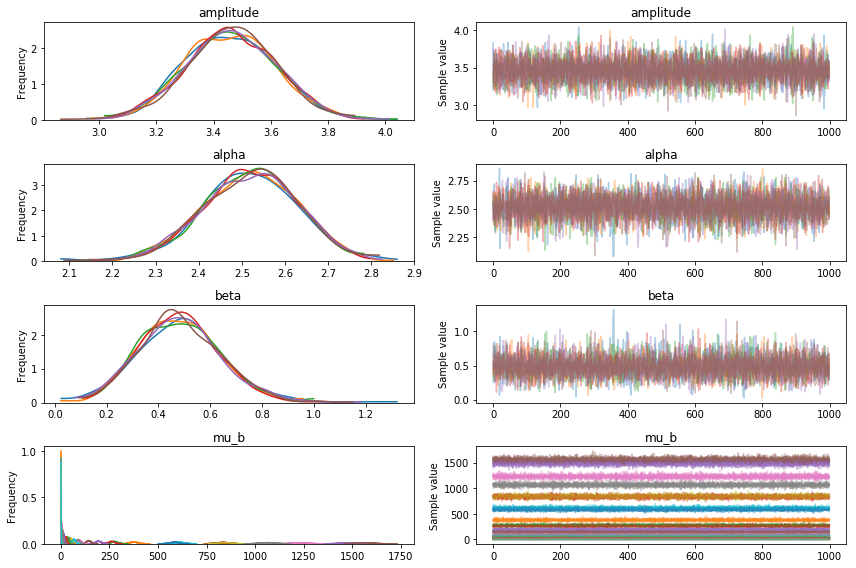

In [61]:
pm.traceplot(trace)

In [62]:
trace['amplitude'].mean(), '+-', trace['amplitude'].std(), trace['alpha'].mean(), '+-', trace['alpha'].std(), trace['beta'].mean(), '+-', trace['beta'].std()

(3.459432,
 '+-',
 0.15592732,
 2.5179293,
 '+-',
 0.10876174,
 0.4813724,
 '+-',
 0.15609986)

In [52]:
trace['amplitude'].mean(), '+-', trace['amplitude'].std(), trace['alpha'].mean(), '+-', trace['alpha'].std(), trace['beta'].mean(), '+-', trace['beta'].std()

(3.5367434,
 '+-',
 0.3882176,
 2.5176954,
 '+-',
 0.11046436,
 0.47932845,
 '+-',
 0.15818541)

/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad84686128>,
      dtype=object)

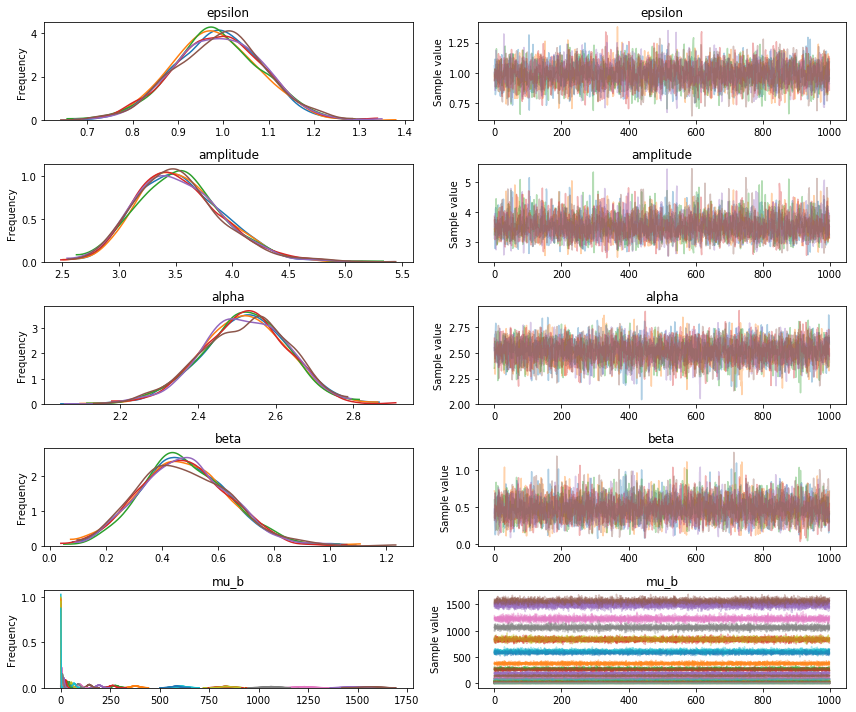

In [47]:
pm.traceplot(trace)

In [43]:
with model:
    samples = pm.sample_ppc(trace)

100%|██████████| 1000/1000 [00:29<00:00, 33.42it/s]


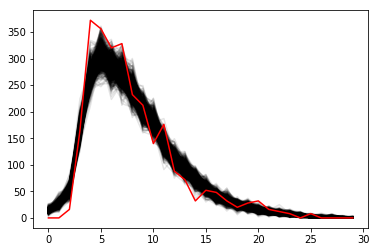

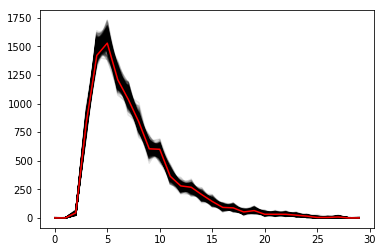

In [44]:
plt.figure()
plt.plot(samples['signal'].T, color='k', alpha=0.1)
plt.plot(on_data, color='red')

plt.figure()
plt.plot(samples['background'].T, color='k', alpha=0.1)
plt.plot(off_data, color='red')

None

In [45]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_mu_b__0,-8.417000,5.999000,0.116,-20.297,0.461,2848.547,1.000
log_mu_b__1,-8.375000,5.974000,0.114,-20.025,0.816,2910.298,1.002
log_mu_b__2,3.700000,0.149000,0.002,3.405,3.981,5178.283,1.000
log_mu_b__3,6.721000,0.034000,0.000,6.653,6.786,5528.828,1.000
log_mu_b__4,7.301000,0.026000,0.000,7.250,7.350,5997.464,1.001
log_mu_b__5,7.350000,0.025000,0.000,7.302,7.399,5710.054,1.000
log_mu_b__6,7.111000,0.029000,0.000,7.053,7.166,5578.858,1.000
log_mu_b__7,6.966000,0.030000,0.000,6.905,7.024,4652.877,1.000
log_mu_b__8,6.729000,0.035000,0.000,6.662,6.798,5954.796,1.001
log_mu_b__9,6.408000,0.040000,0.001,6.330,6.487,6110.603,1.000


In [49]:
np.median(trace['amplitude']), np.median(trace['alpha']), np.median(trace['beta'])

(3.503178, 2.521893, 0.47097588)

In [20]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


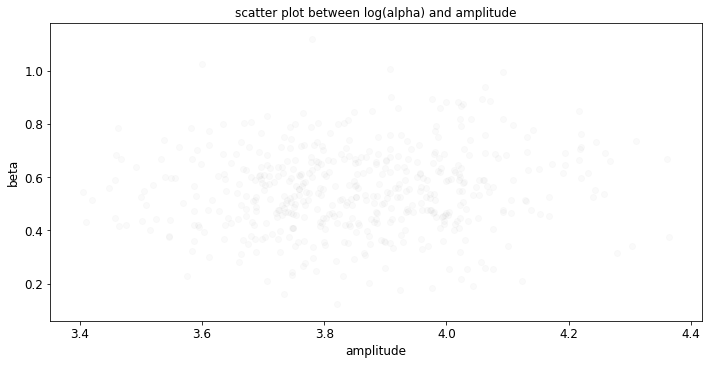

In [98]:
pm.pairplot(trace,
           sub_varnames=['amplitude', 'beta'],
           divergences=True,
           color='k', alpha=0.02, figsize=(10, 5), kwargs_divergence={'color':'C2'})
plt.title('scatter plot between log(alpha) and amplitude');

In [112]:
from collections import defaultdict
divergent_point = defaultdict(list)

chain_warn = trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in model.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in model.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])

ii = 5
amplitude_log_d = divergent_point['amplitude_log__']
# print(divergent_point)
mu_5_d = divergent_point['log_mu_b'][:, ii]
Ndiv_recorded = len(divergent_point['log_mu_b'])
mu_5_d

IndexError: too many indices for array

KeyError: 'mu_b_log___5'

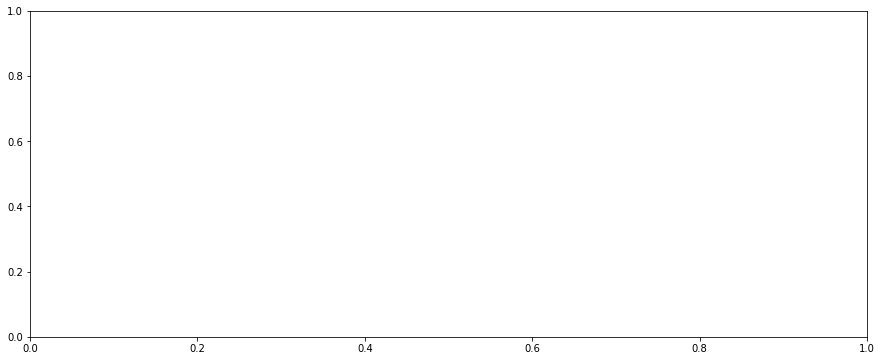

In [104]:
param = 'alpha_log__'
parameter_log_divergence = divergent_point[param]

_, ax = plt.subplots(1, 1, figsize=(15, 6))
pm.pairplot(trace,
               sub_varnames=['mu_b_log___5', param],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

mu_trace = trace['mu_b_log__']
mu_0 = mu_trace[:, 5]

plt.plot([mu_0[divergent == 1][:Ndiv_recorded], mu_0_d], 
         [trace[param][divergent == 1][:Ndiv_recorded], parameter_log_divergence], 'k-', alpha=.25)

plt.scatter(mu_0_d, parameter_log_divergence,
              color='C3', alpha=.9, label='Location of Energy error (start location of leapfrog)')
# ax.scatter(divsp.T, 'C3', lw=.5)
# plt.title('scatter plot between log(tau) and theta[0]')
plt.legend()


In [113]:
tracedf = pm.trace_to_dataframe(trace)
plotorder = ['amplitude', 'alpha', 'beta'] + [f'mu_b__{i}' for i in range(len(off_data))]
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 1, figsize=(12, 5))
# ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
# ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.01)
ax.plot(tracedf.values[divergent == 1].T, color='C2', lw=2)
divsp = np.hstack([divergent_point['amplitude_log__'][:,None],
                   divergent_point['alpha_log__'][:,None],
                   divergent_point['beta_log__'][:,None],
                   divergent_point['mu_b_log__']
                  ])
ax.plot(divsp.T, 'C3', lw=.5)

plt.xticks(range(len(off_data)), plotorder)
plt.tight_layout()


KeyError: "['mu_b__0' 'mu_b__1' 'mu_b__2' 'mu_b__3' 'mu_b__4' 'mu_b__5' 'mu_b__6'\n 'mu_b__7' 'mu_b__8' 'mu_b__9' 'mu_b__10' 'mu_b__11' 'mu_b__12' 'mu_b__13'\n 'mu_b__14' 'mu_b__15' 'mu_b__16' 'mu_b__17' 'mu_b__18' 'mu_b__19'\n 'mu_b__20' 'mu_b__21' 'mu_b__22' 'mu_b__23' 'mu_b__24' 'mu_b__25'\n 'mu_b__26' 'mu_b__27' 'mu_b__28' 'mu_b__29' 'mu_b__30' 'mu_b__31'\n 'mu_b__32' 'mu_b__33'] not in index"